<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-phoenix-assets/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Multimodal LLM Ops - Tracing, Evaluation, and Analysis of Multimodal Models</h1>

This tutorial will teach you how to build, observe, evaluate, and analyze a multimodal LLM application for a image reasoning usecase. 

It has the following sections:

1. TBD
2. TBD
3. TBD
4. TBD
5. TBD

⚠️ This tutorial requires an OpenAI key to run

⚠️ The following Llama-Index [tutorial](https://docs.llamaindex.ai/en/stable/examples/multi_modal/gpt4v_multi_modal_retrieval/?h=tesla+images) was used as inspiration

# Advanced Multi-Modal Retrieval using GPT4V and Multi-Modal Index/Retriever

In this notebook, we show how to use a Mult-Modal LLM, i.e., OpenAI's `gpt-4o`, to ask questions about images (image reasoning) using the chat API. In addition, we use Arize's Phoenix and OpenInference AutoInstrumentor to trace the operation.

- Framework: [LlamaIndex](https://github.com/run-llama/llama_index)
- LLM: OpenAI's GPT-4o
- LLM Observability: [Arize Phoenix](https://phoenix.arize.com/) ([GitHub](https://github.com/Arize-ai/phoenix))
- LLM Tracing: Arize's [OpenInference](https://arize-ai.github.io/openinference/) [Auto-Instrumentor](https://github.com/Arize-ai/openinference/tree/main/python/instrumentation/openinference-instrumentation-llama-index)

Steps:
1. Install dependencies
2. Setup Tracing
2. Download Images from Tesla
3. Setup the Multi-Modal LLM application
4. Use the Multi-Modal LLM pplication

## Install dependencies

In [1]:
# Observability & Tracing dependencies
%pip install -qq arize-phoenix openinference-instrumentation-llama-index
# Framework dependencies
%pip install -qq llama-index
# Other dependencies: so that we can show and understand the images in this notebook
%pip install -qq matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Setup Tracing

First, we launch the phoenix app, which will act as an OTEL collector of the generated spans. 

In [2]:
import phoenix as px

px.launch_app()

/Users/kikocastillo/anaconda3/envs/tesla-llama-index-example/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:phoenix.config:📋 Ensuring phoenix working directory: /Users/kikocastillo/.phoenix


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


Next, we setup the tracing by declaring a tracer provider and a span processor with an OTLP span exporter:

In [3]:
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk import trace as trace_sdk
from opentelemetry.sdk.trace.export import BatchSpanProcessor

endpoint = "http://127.0.0.1:6006/v1/traces"
tracer_provider = trace_sdk.TracerProvider()
tracer_provider.add_span_processor(BatchSpanProcessor(OTLPSpanExporter(endpoint)))

Finally, we use OpenInference's Llama-Index auto-instrumentor.

In [4]:
from openinference.instrumentation import TraceConfig
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor

config = TraceConfig(base64_image_max_length=100_000_000)
LlamaIndexInstrumentor().instrument(
    tracer_provider=tracer_provider,
    config=config,
    skip_dep_check=True,
)

That's it! With these 2 cells you have correctly set up the tracing of your Llama-Index application. As you use this application, spans will be exported to Phoenix for observability and analysis.

## Download images from Tesla's website

In [5]:
from pathlib import Path

input_image_path = Path("input_images")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

In [6]:
%%capture
!wget "https://docs.google.com/uc?export=download&id=1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj" -O ./input_images/long_range_spec.png
!wget "https://docs.google.com/uc?export=download&id=19pLwx0nVqsop7lo0ubUSYTzQfMtKJJtJ" -O ./input_images/model_y.png
!wget "https://docs.google.com/uc?export=download&id=1utu3iD9XEgR5Sb7PrbtMf1qw8T1WdNmF" -O ./input_images/performance_spec.png
!wget "https://docs.google.com/uc?export=download&id=1dpUakWMqaXR4Jjn1kHuZfB0pAXvjn2-i" -O ./input_images/price.png
!wget "https://docs.google.com/uc?export=download&id=1qNeT201QAesnAP5va1ty0Ky5Q_jKkguV" -O ./input_images/real_wheel_spec.png

I0000 00:00:1723462679.625561 1704538 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1723462683.937175 1704538 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1723462687.901426 1704538 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1723462690.647327 1704538 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1723462694.238852 1704538 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


Next, we simply plot the images so you know what we just downloaded

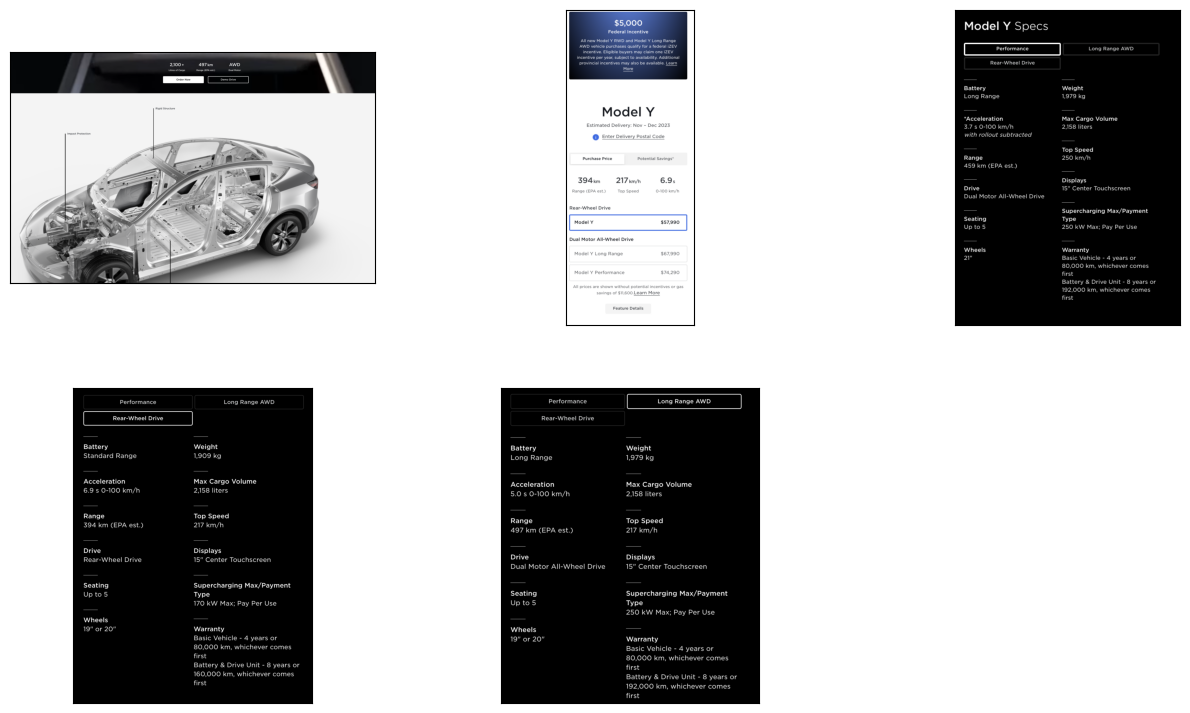

In [7]:
import os

import matplotlib.pyplot as plt
from PIL import Image

image_paths = []
for img_path in os.listdir("./input_images"):
    image_paths.append(str(os.path.join("./input_images", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

## Setup the Multi-Modal LLM application

First things first, we need an OpenAI (our LLM provider) API key.

In [8]:
import os
from getpass import getpass

if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")

os.environ["OPENAI_API_KEY"] = openai_api_key

Last, we need to declare our OpenAI from the `multi_nmodal_llms` module and use a `SimpleDirectoryReader` to have access to the downloaded images

In [9]:
from llama_index.core import SimpleDirectoryReader
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

# put your local directory here
image_documents = SimpleDirectoryReader("./input_images").load_data()

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o",
    max_new_tokens=1500,
)

## Use the Multi-Modal LLM application

We set up multimodal chat messages and call the LLM

In [10]:
from llama_index.multi_modal_llms.openai.utils import (
    generate_openai_multi_modal_chat_message,
)

# Setup first message: a question about the passed image documents
message_1 = generate_openai_multi_modal_chat_message(
    prompt="Describe the images as an alternative text",
    role="user",
    image_documents=image_documents,
)

# Call the LLM for a response to the question
response_1 = openai_mm_llm.chat(
    messages=[message_1],
)

print(response_1)

I0000 00:00:1723462698.050395 1704538 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


assistant: 1. **Image 1:**
   - Title: Performance, Rear-Wheel Drive, Long Range AWD
   - Battery: Long Range
   - Weight: 1,979 kg
   - Acceleration: 5.0 s 0-100 km/h
   - Max Cargo Volume: 2,158 liters
   - Range: 497 km (EPA est.)
   - Top Speed: 217 km/h
   - Drive: Dual Motor All-Wheel Drive
   - Displays: 15" Center Touchscreen
   - Seating: Up to 5
   - Supercharging Max/Payment Type: 250 kW Max; Pay Per Use
   - Wheels: 19" or 20"
   - Warranty: Basic Vehicle - 4 years or 80,000 km, whichever comes first; Battery & Drive Unit - 8 years or 192,000 km, whichever comes first

2. **Image 2:**
   - A semi-transparent image of a car showing its internal structure. Labels indicate "Impact Protection" and "Rigid Structure." The top section of the image has options for "Order Now" and "Demo Drive," with specifications such as "2,100+ Liters of Cargo," "497 km Range (EPA est.)," and "AWD Dual Motor."

3. **Image 3:**
   - Title: Model Y Specs
   - Performance, Rear-Wheel Drive, Long Rang

We can also simulate a conversation by passing the response as a message from the "assistant", and ask further questions

In [11]:
message_2 = generate_openai_multi_modal_chat_message(
    prompt=response_1.message.content,
    role="assistant",
)

message_3 = generate_openai_multi_modal_chat_message(
    prompt="Can you tell me what the price of each spec as well?",
    role="user",
    image_documents=image_documents,
)
response_2 = openai_mm_llm.chat(
    messages=[
        message_1,
        message_2,
        message_3,
    ],
)

print(response_2)

assistant: The images provided do not specify the prices for each spec directly. However, the fourth image does provide some pricing information for the Model Y:

- **Model Y (Rear-Wheel Drive):** $57,990
- **Model Y Long Range:** $67,990
- **Model Y Performance:** $74,290

These prices are shown without potential incentives and gas savings of $11,600. For the exact prices of each spec, you would typically need to visit the manufacturer's website or contact a dealership.


Let's try make the last question more difficult. We can ask the last question without directly passing the image documents. Sometimes the LLM will rembemer the images passed in the first message and responde correctly. However, some other times it will be unaware of them and give an incomplete or wrong answer.

In [12]:
message_3_no_images = generate_openai_multi_modal_chat_message(
    prompt="Can you tell me what the price of each spec as well?",
    role="user",
)
response_3 = openai_mm_llm.chat(
    messages=[
        message_1,
        message_2,
        message_3_no_images,
    ],
)

print(response_3)

assistant: The images provided do not explicitly list the prices for each specific configuration of the vehicle. However, the fourth image does provide some pricing information for the Model Y:

- **Model Y (Base Model):** $57,990
- **Model Y Long Range:** $67,990
- **Model Y Performance:** $74,290

These prices are shown without potential incentives and gas savings of $11,600. For more detailed pricing of each specific configuration, it would be best to visit the manufacturer's website or contact a dealership directly.


## Observability

Now that we've run the application a couple of times, let's take a look at the traces in the UI:

In [13]:
print("The Phoenix UI:", px.active_session().url)

The Phoenix UI: http://localhost:6006/


The UI will give you an interactive troubleshooting experience. You can sort, filter, and search for traces. You can also view the questions asked and the images in the message. For instance you can see how in the second trace, the images were passed to every user message, but in the third trace only the first message had the images attached.